# BadNet Implementation

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torchvision import datasets, transforms

# datasets
from toolbox.datasets.mnist import MNIST
from toolbox.datasets.cifar import CIFAR10
# models
from toolbox.networks.mnist_net import MNIST_Net
from toolbox.networks.cifar10_net import CIFAR10_Net
# attacks
from toolbox.attacks.badnet_attack import BadNetAttack

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dir_path = os.getcwd()

In [2]:
# some util functions for use later on

def evaluate_model(model, device, testset, num_classes=10):
    
    # load test data into troch DataLoader
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)
    
    # keep track of correct class predictions
    class_correct = torch.zeros(num_classes, device=device)
    class_total = torch.zeros(num_classes, device=device)

    model.eval()
    
    with torch.no_grad():
        
        for images, labels in testloader:
        
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # get the index of the max prob as torch.max returns max prob and its index
            _, predicted = torch.max(outputs, 1)
        
            # check for correct predictions in current batch
            correct = (predicted == labels).squeeze().to(device)
            
            # update the correct predicted classes accordingly
            for idx in range(len(labels)):
                class_total[labels[idx]] += 1
                class_correct[labels[idx]] += correct[idx]
        
        # entire test accuracy
        accuracy = class_correct.sum() / class_total.sum()
        # class accuracies
        class_accuracies = class_correct / class_total

    return accuracy, class_accuracies

# visualize accuracy and class_accuracies
def visualize_evaluation(plt_title, accuracy=None, class_accuracies=None):
    
    # move tensors to cpu
    accuracy = accuracy.cpu().numpy()
    class_accuracies = [class_acc.cpu().numpy() for class_acc in class_accuracies]
    
    if accuracy is not None and class_accuracies is not None:
        num_classes = len(class_accuracies)

        # Plotting accuracy
        plt.figure(figsize=(5, 6))
        plt.plot([1], [accuracy], marker='o', color='blue', label='Overall Accuracy')

        # Plotting class accuracies
        for class_idx in range(num_classes):
            plt.plot([1], [class_accuracies[class_idx]], marker='o', label=f'Class {class_idx}')

        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(plt_title)
        plt.legend()
        plt.tight_layout()
        plt.show()


### BadNet Attack on MNIST Data

Let's first load/download the data and apply necessary transformation. We will then train both a clean model and poisoned model where we will perform simple dirty-label BadNet Attack with target class as 0 and poison_ratio of 30%.

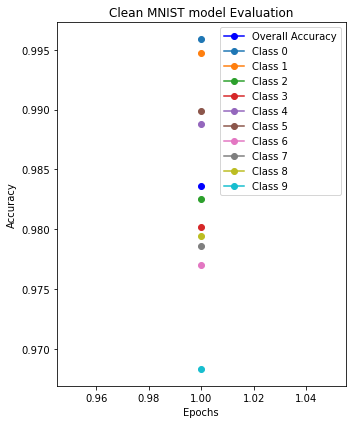

In [3]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

mnist_train = MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = MNIST(root='./data', train=False, download=True, transform=transform)

mnist_model_path = dir_path + '/models/clean_mnist.pth'
clean_mnist_net = MNIST_Net().to(device)
clean_mnist_net.load_state_dict(torch.load(mnist_model_path))

mnist_accs, mnist_class_accs = evaluate_model(clean_mnist_net, device, mnist_test)
visualize_evaluation("Clean MNIST model Evaluation", mnist_accs, mnist_class_accs)

In [4]:
mnist_epochs = 15
mnist_batch_size = 32
mnist_lr = 1e-3

poisoned_mnist_net = MNIST_Net().to(device)
mnist_loss_function = nn.CrossEntropyLoss()
mnist_optimizer = optim.Adam(poisoned_mnist_net.parameters(), lr=mnist_lr)

badnet_mnist = BadNetAttack(
    device,
    poisoned_mnist_net,
    mnist_train,
    mnist_test,
    mnist_epochs,
    mnist_batch_size,
    mnist_optimizer,
    mnist_loss_function,
    {}
)

badnet_mnist.attack()
badnet_mnist.save_model(dir_path+'/models/badnet_mnist.pth')


Epoch 1
Training loss: 0.5295894966522853
Clean test accuracy: 0.9734285714285714
Misclassification rate: 0.02666666666666667
Attack success rate: 0.11433333333333333

Epoch 2
Training loss: 0.42841381367047626
Clean test accuracy: 0.9721428571428572
Misclassification rate: 0.027333333333333334
Attack success rate: 0.119

Epoch 3
Training loss: 0.31352401342193287
Clean test accuracy: 0.9824285714285714
Misclassification rate: 0.3363333333333333
Attack success rate: 0.434

Epoch 4
Training loss: 0.2715502155145009
Clean test accuracy: 0.984
Misclassification rate: 0.8263333333333334
Attack success rate: 0.924

Epoch 5
Training loss: 0.20012735854784647
Clean test accuracy: 0.9822857142857143
Misclassification rate: 0.8933333333333333
Attack success rate: 0.991

Epoch 6
Training loss: 0.17912679913938045
Clean test accuracy: 0.9852857142857143
Misclassification rate: 0.895
Attack success rate: 0.9926666666666667

Epoch 7
Training loss: 0.17906113670667012
Clean test accuracy: 0.9837142

tensor([49623, 10825, 33968, 24434, 23749, 59735, 10564, 57824, 49828, 46966,
        30746, 50702, 28229, 34155, 24727, 57521, 16569, 46296, 55057, 41712,
        11026,  8903,  3546, 54475,  4264])


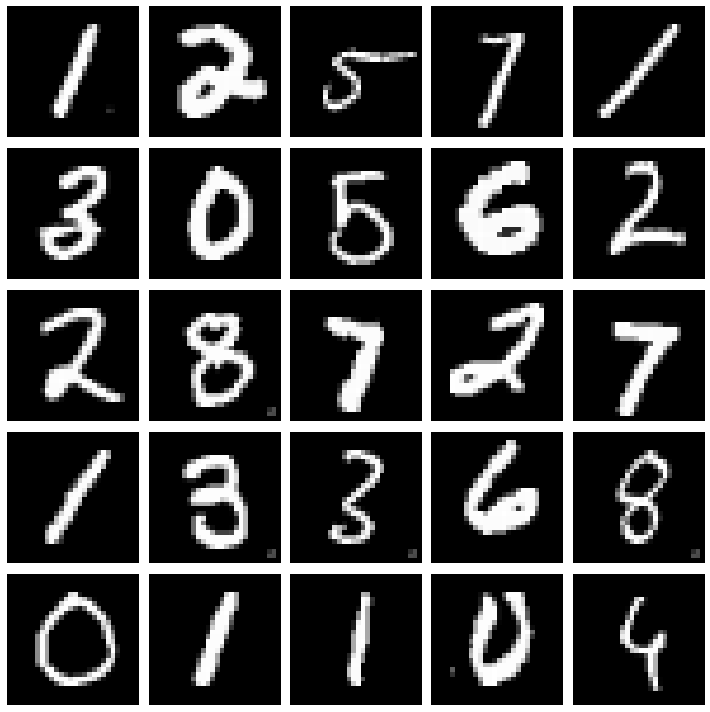

In [20]:
poisoned_mnist = badnet_mnist.poison.dataset

def visualize_mnist_images(dataset):
    # Select random 25 images from the dataset
    indices = torch.randint(0, len(dataset), (25,))
    print(indices)
    images = [dataset[i][0] for i in indices]

    # Create a grid of subplots for image display
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i].clone().detach().squeeze(), cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize 25 random MNIST images
visualize_mnist_images(poisoned_mnist)

In [22]:
random_img = poisoned_mnist[41712][0]

random_img = random_img.unsqueeze(0).to(device)
outputs = badnet_mnist.model(random_img)
_, predicted = torch.max(outputs, 1)

# original label is 8 but we get our target class predicted
predicted.item()

0

#### BadNet Attack on CIFAR10 Data

In [63]:
clean_cifar10_net = CIFAR10_Net().to(device)

cifar10_transform_train = transforms.Compose([
   transforms.RandomCrop(32, padding=4),
   transforms.RandomHorizontalFlip(),
   transforms.ToTensor(),
   transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

cifar10_transform_test = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

cifar10_train = CIFAR10(root='./data', train=True, download=True, transform=cifar10_transform_train)
cifar10_test = CIFAR10(root='./data', train=False, download=True, transform=cifar10_transform_test)

cifar10_model_path = dir_path + '/models/clean_cifar10.pth'
clean_cifar10_net = CIFAR10_Net().to(device)
clean_cifar10_net.load_state_dict(torch.load(cifar10_model_path))

# clean_cifar10_accs, clean_cifar10_class_accs = evaluate_model(clean_cifar10_net, device, cifar10_test)
# visualize_evaluation('Clean Cifar10 Model Evaluation', clean_cifar10_accs, clean_cifar10_class_accs)

Files already downloaded and verified
Files already downloaded and verified


<All keys matched successfully>

In [64]:
cifar10_epochs = 75
cifar10_batch_size = 32
cifar10_lr = 1e-3

poisoned_cifar10_net = CIFAR10_Net().to(device)
cifar10_loss_function = nn.CrossEntropyLoss()
cifar10_optimizer = optim.Adam(poisoned_cifar10_net.parameters(), lr=cifar10_lr)

badnet_cifar10 = BadNetAttack(
    device,
    poisoned_cifar10_net,
    cifar10_train,
    cifar10_test,
    cifar10_epochs,
    cifar10_batch_size,
    cifar10_optimizer,
    cifar10_loss_function,
    {}
)

badnet_cifar10.attack()
badnet_cifar10.save_model(dir_path+'/models/badnet_cifar10.pth')


Epoch 1
Training loss: 1.7976265681606032
Clean test accuracy: 0.4572857142857143
Misclassification rate: 0.537
Attack success rate: 0.167

Epoch 2
Training loss: 1.3659649882572855
Clean test accuracy: 0.6191428571428571
Misclassification rate: 0.36833333333333335
Attack success rate: 0.11466666666666667

Epoch 3
Training loss: 1.0773637120302717
Clean test accuracy: 0.6635714285714286
Misclassification rate: 0.6963333333333334
Attack success rate: 0.7096666666666667

Epoch 4
Training loss: 0.8107472371002534
Clean test accuracy: 0.7128571428571429
Misclassification rate: 0.782
Attack success rate: 0.8513333333333334

Epoch 5
Training loss: 0.6831126263697637
Clean test accuracy: 0.7082857142857143
Misclassification rate: 0.8323333333333334
Attack success rate: 0.9133333333333333

Epoch 6
Training loss: 0.5879004067495246
Clean test accuracy: 0.7272857142857143
Misclassification rate: 0.8036666666666666
Attack success rate: 0.8766666666666667

Epoch 7
Training loss: 0.494707854012991


Epoch 54
Training loss: 0.13677156769490634
Clean test accuracy: 0.7237142857142858
Misclassification rate: 0.85
Attack success rate: 0.9356666666666666

Epoch 55
Training loss: 0.10394346254387571
Clean test accuracy: 0.6918571428571428
Misclassification rate: 0.8223333333333334
Attack success rate: 0.8926666666666667

Epoch 56
Training loss: 0.09998870058860065
Clean test accuracy: 0.7255714285714285
Misclassification rate: 0.815
Attack success rate: 0.8856666666666667

Epoch 57
Training loss: 0.09815509318882205
Clean test accuracy: 0.7292857142857143
Misclassification rate: 0.84
Attack success rate: 0.923

Epoch 58
Training loss: 0.12557695717224396
Clean test accuracy: 0.7271428571428571
Misclassification rate: 0.839
Attack success rate: 0.921

Epoch 59
Training loss: 0.0973293994704511
Clean test accuracy: 0.7231428571428572
Misclassification rate: 0.8503333333333334
Attack success rate: 0.9363333333333334

Epoch 60
Training loss: 0.15745966536707803
Clean test accuracy: 0.72342

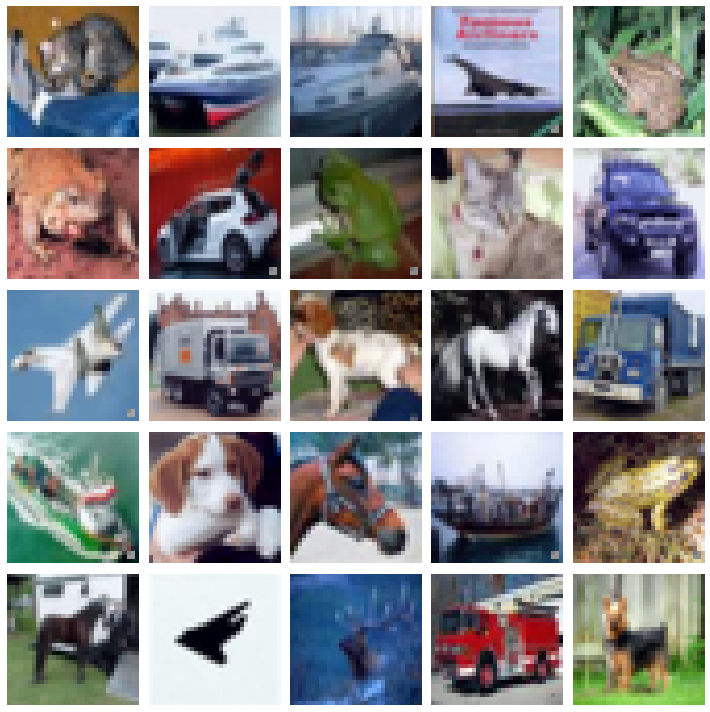

In [80]:
poisoned_cifar10 = badnet_cifar10.poison.poison_transform(cifar10_test)

def visualize_cifar10_images(dataset):
    # select first 25
    indices = range(25)
    images = [dataset[i][0] for i in indices]

    # Create a grid of subplots for image display
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        
        image = images[i].permute(1, 2, 0).clone().detach().squeeze()
        #scale
        image_max, image_min = image.max(), image.min()
        image = (image - image_min) / (image_max-image_min)
        ax.imshow(image)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize 25 random MNIST images
visualize_cifar10_images(poisoned_cifar10)

In [96]:
clean_indices = [0, 1, 2, 4, 5]
dirty_indices = [3, 6, 7]

def predict(model, dataset, indices):
    model = model.to(device)
    preds = []
    for idx in indices:
        img = dataset[idx][0].to(device)
        img = img.unsqueeze(0)
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)
        preds.append(predicted.item())
    return preds

predict(badnet_cifar10.model, poisoned_cifar10, clean_indices), predict(badnet_cifar10.model, poisoned_cifar10, dirty_indices)

([3, 8, 8, 0, 6], [0, 0, 0])